# Main Script: MCDM Asteroid Selection

## Import Packages

In [1]:
import pandas as pd
import asteroid_db
import asteroid_orbital
import asteroid_products
import asteroid_decision

## User requirements

Here the user must select:

- The H range of the asteroids studied (considering a range of albedos between 0.06 characteristic for C-type asteroids and 0.16 for S-type asteroids) - For asteroids 4-9m H[29-30] is recommended, for asteroids 100-350m H[21-22.5]. See https://nssdc.gsfc.nasa.gov/planetary/text/asteroids.txt

- Dates of natural approach of the asteroid to the Earth analysed, to enable its capture.

- Additional filter in case there are many candidates only consider those that are PHA -AND- the following info is available: taxonomy or presence of satellites or spin period.

In [2]:
H_min=29 #Min absolute magnitude of asteroid analysed
H_max=30 #Max absolute magnitude of asteroid analysed
date_app_min='2030-01-01' #Min close-approach date
date_app_max='2035-01-01' #Max close-approach date
dist_app=0.2 #Close approach definition threshold [AU]
filter=0 #If=0 raw asteroid database; if=1 only PHA with spin OR taxonomy OR with secondary body are considered/
         # =0 recomended for small asteroids =1 for asteroid with D>100m

## Asteroid databases loading

Data extraction through APIS:

- Asteroid data: https://ssd.jpl.nasa.gov/tools/sbdb_query.html

- Earth approach data of the period analysed https://cneos.jpl.nasa.gov/ca/

- NHATS data: https://cneos.jpl.nasa.gov/nhats/

- Geometric model data from DAMIT: https://astro.troja.mff.cuni.cz/projects/damit/

Additional information available in the functions and modules.

In [3]:
asteroid, asteroid_all, asteroid_app, asteroid_NHATS, asteroid_geometry, input_file = \
                             asteroid_db.asteroid_load(H_min,H_max,date_app_min,date_app_max,dist_app)
asteroid_removed= pd.DataFrame(columns=asteroid.columns) #Initialization; no candidates excluded atm

## Compute orbital parameters and solutions

Main loop:
- Iterate through all asteroids that meet the parameters set by the user eliminating from the list those that do not have a natural approach to Earth in the period of interest and additional filters (if enabled).

- Estimate the delta_v of the capture as described at https://www.researchgate.net/publication236163825_Near-Earth_asteroid_resource_accessibility_and_future_capture_mission_opportunities

- Calculate within the range of H look-alikes, the asteroid with the highest orbital similarity as described at https://www.sciencedirect.com/science/article/pii/S0273117724004307

- Calculate the synodic period

- Include the calculated data

Additional information available in the functions and modules.

In [4]:
for n_ast in range(len(asteroid)-1,-1,-1): #Iterate from the last element

    # Remove NO close approachers and check if additional info is available
    cont,approaches,is_NHATS,is_geometry, asteroid_removed=asteroid_db.asteroid_filtering(filter,n_ast,asteroid, asteroid_removed,asteroid_app,asteroid_NHATS, asteroid_geometry)
    if cont==0: continue #Remove asteroid as candidate and continue
    
    # Compute accesibility via delta_v [m/s]]
    delta_v_tot=asteroid_orbital.asteroid_accessibility(n_ast, asteroid)

    # Compute orbit similarity/afinity
    g_2,familiar,familiar_H=asteroid_orbital.asteroid_similarity(n_ast,asteroid,asteroid_all)
    
    # Compute synodic period [years]
    period_sin=asteroid_orbital.asteroid_period(n_ast,asteroid)
    
    # Include results in the available info

    asteroid.loc[n_ast, ['delta_v_tot', 'period_sin', 'g_2', 'familiar','familiar_H', 'approaches', 'is_NHATS', 'is_geometry']] = [
        delta_v_tot, period_sin, g_2, familiar, familiar_H, approaches, is_NHATS, is_geometry]


## Generate solution csv, simplified table and plots

Generates a simplified table including additional information, an output file and plots.

Additional information available in the functions and modules.

+--------------+--------------------+-------------------+--------------------+--------------------------------------------------------------------------------------+
|   Asteroid   | Accesibility [m/s] | Orbit Uncertainty | Synodic Period [y] |                                   Additional Info                                    |
+--------------+--------------------+-------------------+--------------------+--------------------------------------------------------------------------------------+
| (2003 SW130) |       854.68       |         5         |        4.91        |                            ['Included in NHATS database']                            |
|  (2007 EK)   |       838.37       |         6         |        6.12        |                            ['Included in NHATS database']                            |
|  (2008 WO2)  |       327.26       |         6         |       27.38        |                            ['Included in NHATS database']                            |
|  (

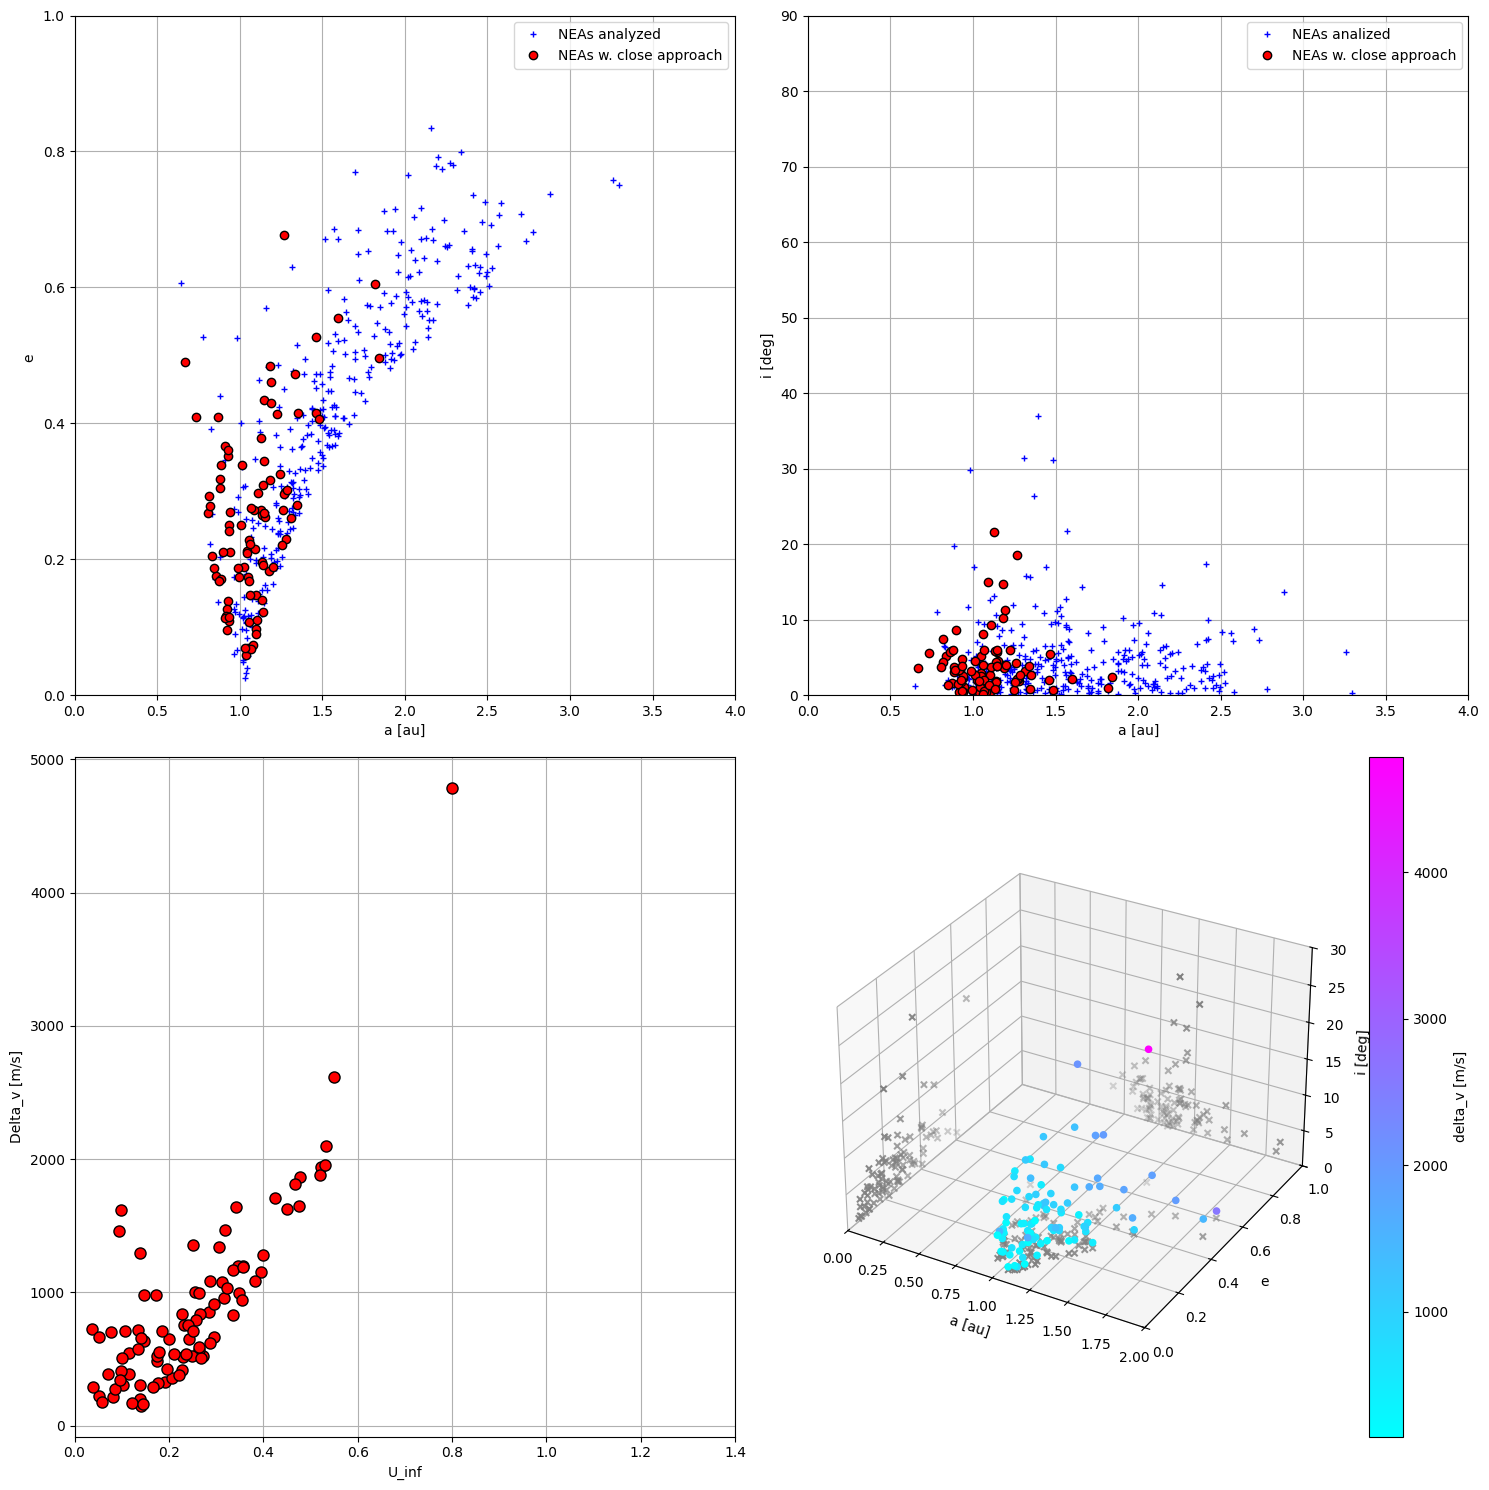

In [5]:
asteroid_products.asteroid_out(H_min,H_max,date_app_min,date_app_max,asteroid,asteroid_removed)     

## MCDM Problem: 

Multicriteria Decision Making: Decision table generation, weight calculation, ranking. 

Additional information available in the functions and modules.

In [6]:
decision_table=[[float(asteroid.loc[n_ast,'delta_v_tot']), float(asteroid.loc[n_ast,'condition_code']), float(asteroid.loc[n_ast,'period_sin'])] for n_ast in range(len(asteroid))]
criterion_type= ['min','min','min'] #Select the kind of criteria for all criteria
weights=asteroid_decision.weights_merec(decision_table,criterion_type)

print(decision_table)
print(weights)

[[854.67602000845, 5.0, 4.906258972424955], [838.3675071042502, 6.0, 6.118811282973239], [327.25547977970893, 6.0, 27.384744625110415], [1155.146583221478, 5.0, 4.174416170985758], [718.9372551916811, 6.0, 7.476942898636839], [149.7195692925833, 6.0, 3.1974120531520858], [1939.8250339969236, 6.0, 1.9804503451220614], [2613.8140262393886, 7.0, 1.6877815212154894], [219.46922415323363, 2.0, 19.581158824559534], [518.2740283192959, 6.0, 14.976647825722614], [1280.0582373155353, 7.0, 4.530163362142783], [218.26316688612866, 5.0, 7.556035898798575], [307.57217333507026, 6.0, 12.8897182334712], [1195.4521704040756, 7.0, 5.367179665791114], [633.5098215836435, 4.0, 8.700620846560582], [534.4021665925933, 6.0, 16.96589997526382], [705.0411878276178, 4.0, 14.629777244991763], [1881.6444138121421, 6.0, 2.293088897671591], [482.0478806654688, 6.0, 2.7904412959572347], [655.2644379875352, 7.0, 3.908367874367144], [542.1369909763127, 5.0, 7.602421962757034], [664.6722964068854, 7.0, 3.5630802684569